# Predicting On-time Delivery of Online Purchases
## Part III-B: Modeling - Naive Bayes Classifier
## AAI-510 Team 7 Final Project

Team 7:  Ken Devoe, Tyler Foreman, Geoffrey Fadera

University of San Diego, Applied Artificial Intelligence

Date:  June 24, 2024

GitHub Repository: https://github.com/kdevoe/aai510-group7

## Import Common Functions

In [10]:
%run shipping_common_functions.ipynb

## Imports

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## Load Preprocessed Data

In [3]:
# train data
X_train = pd.read_csv('./data/x_train.csv')
y_train = np.ravel(pd.read_csv('./data/y_train.csv'))

# val data
X_val = pd.read_csv('./data/x_val.csv')
y_val = np.ravel(pd.read_csv('./data/y_val.csv'))

In [4]:
# Check imported data
print('TRAIN SET:')
print('   X_train:', X_train.shape)
print('   y_train:', y_train.shape)
print('\nVALIDATION SET:')
print('   X_val:', X_val.shape)
print('   y_val:', y_val.shape)

TRAIN SET:
   X_train: (8799, 17)
   y_train: (8799,)

VALIDATION SET:
   X_val: (1100, 17)
   y_val: (1100,)


In [5]:
X_train.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,-0.925605,5,-0.670120,-0.378680,1,-0.392911,0.311901,0,0,0,0,1,0,0,1,1,0
1,1.697108,3,-0.173246,0.273631,2,-0.638968,0.532606,1,0,0,0,0,0,0,1,1,0
2,-1.799843,5,1.379486,-0.378680,2,-0.454426,-1.585178,0,0,0,1,0,0,0,1,0,1
3,0.822870,5,0.178707,-1.030992,2,-0.577454,0.406052,0,0,1,0,0,0,0,1,0,1
4,1.697108,3,1.772845,0.273631,1,-0.577454,-1.207352,0,0,1,0,0,1,0,0,1,0


In [6]:
X_val.head()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Discount_offered,Weight_in_gms,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Flight,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Gender_F,Gender_M
0,-0.051367,2,1.213861,-1.030992,2,-0.700483,0.237314,0,0,0,1,0,0,1,0,1,0
1,-0.051367,2,-0.421683,-0.378680,2,-0.392911,0.697675,1,0,0,0,0,0,1,0,0,1
2,-0.051367,1,-0.297464,-1.030992,1,-0.638968,0.689116,0,0,0,1,0,0,0,1,0,1
3,-0.925605,3,-0.152543,-0.378680,2,-0.392911,0.826674,0,0,0,1,0,1,0,0,0,1
4,0.822870,5,0.779096,0.925943,2,-0.331397,-1.066126,1,0,0,0,0,1,0,0,0,1


## Model 1: Decision Tree Classifier

Decision Tree classifier to predict on-time shipments.

### Model 1: Create, Train Model

Start with some standard hyperparameters to initialize the model as a baseline

In [22]:
dt_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=2, criterion='entropy')
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=2)

### Model 1: Describe/Visualize Model

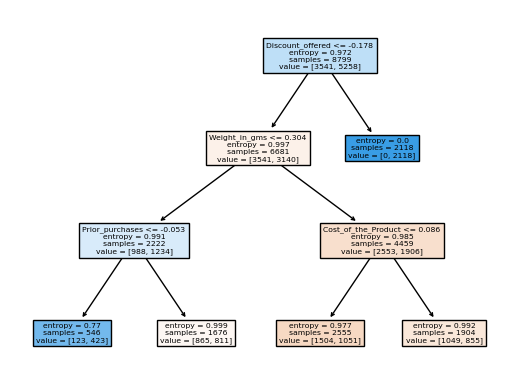

In [28]:
# visualize the tree generated
f_names=list(X_train.columns) 
tree.plot_tree(dt_model, filled=True, feature_names=f_names) 
plt.show() 

### Model 1: Performance on Validation Set

In [23]:
# predict y values based on the validation set
y_pred1 = dt_model.predict(X_val)

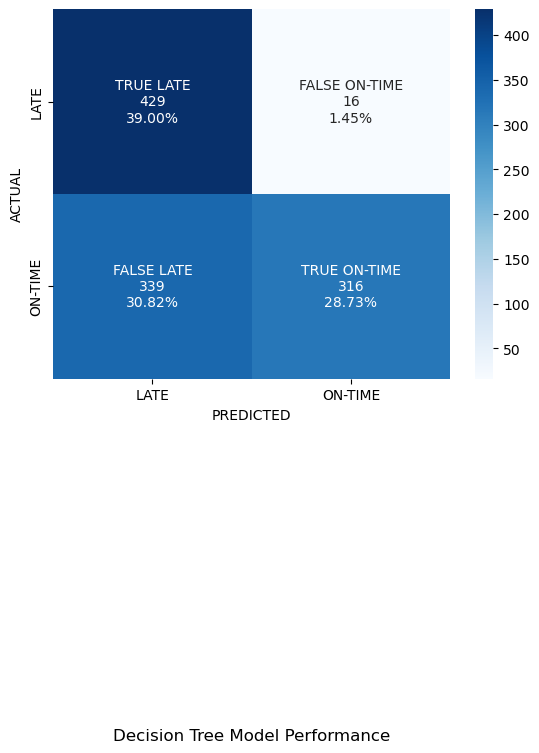

In [26]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1, title = 'Decision Tree Model Performance')

In [25]:
# Generate Classification Report for model 1
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1, title = 'Decision Tree')
    

              precision    recall  f1-score   support

        LATE       0.56      0.96      0.71       445
     ON-TIME       0.95      0.48      0.64       655

    accuracy                           0.68      1100
   macro avg       0.76      0.72      0.67      1100
weighted avg       0.79      0.68      0.67      1100



### Model 1: Hyperparameter Tuning

Perform random search to optimize hyperparameters

In [32]:
# initialize new model
dt_model_tune= DecisionTreeClassifier(random_state=42)

In [33]:
# setup search grid
param_grid = { 
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [2, 3, 4],
    'criterion' :['gini', 'entropy', 'log_loss']
}

In [34]:
# run search
CV_rfc = GridSearchCV(estimator=dt_model_tune, param_grid=param_grid, cv=5, verbose=2)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=2; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=3; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=3; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=3; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=3; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=3; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=4; total time=   0.3s
[CV] END ....criterion=gini, max_depth=3, min_s

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 5, 7],
                         'min_samples_leaf': [2, 3, 4]},
             verbose=2)

In [35]:
CV_rfc.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

In [36]:
# predict y values based on the validation set
y_pred1_tuned = CV_rfc.predict(X_val)

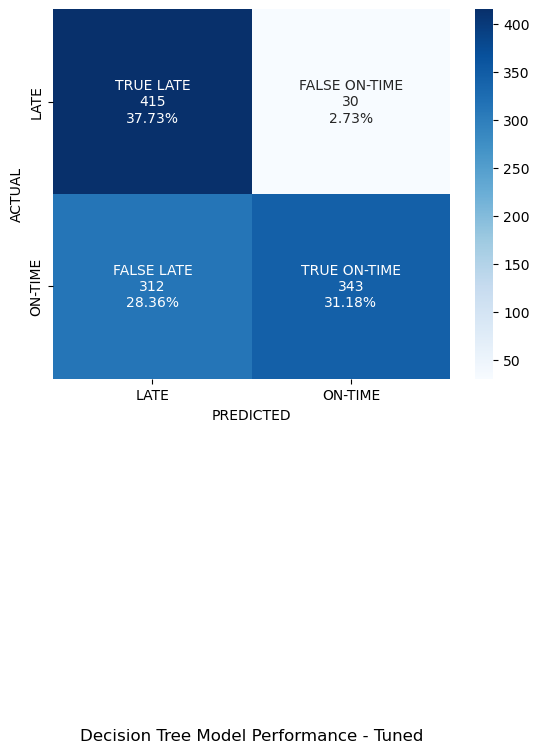

In [38]:
# generate confusion matrix for model1
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred1_tuned, title = 'Decision Tree Model Performance - Tuned')

In [39]:
# Generate Classification Report for model 1 Tuned
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred1_tuned, title = 'Decision Tree - Tuned Hyperparameters')

              precision    recall  f1-score   support

        LATE       0.57      0.93      0.71       445
     ON-TIME       0.92      0.52      0.67       655

    accuracy                           0.69      1100
   macro avg       0.75      0.73      0.69      1100
weighted avg       0.78      0.69      0.68      1100



## Model 2: XGBoost

....

### Model 2: Create, train, evaluate

In [13]:
# fit the model
bst = XGBClassifier(enable_categorical=True).fit(X_train, y_train)

### Model 2: Performance on Validation Set

In [14]:
# predict y values based on the validation set
y_pred2 = bst.predict(X_val)
y_pred2

array([1, 0, 0, ..., 1, 0, 0])

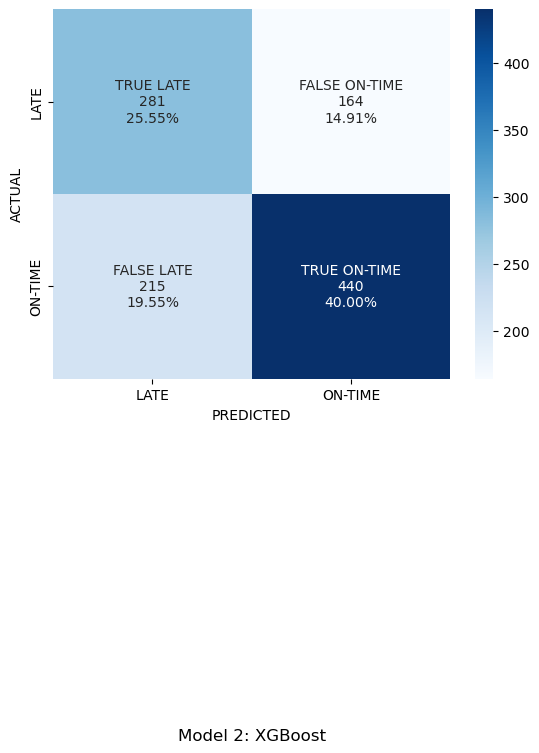

In [15]:
# generate confusion matrix for model2
aai510_grp7_confusion_matrix(y_true = y_val, y_pred = y_pred2, title = 'Model 2: XGBoost')

In [16]:
# Generate Classification Report for model 2
aai510_grp7_class_report(y_true = y_val, y_pred = y_pred2, title = 'Model 2: XGBoost Classifier')

              precision    recall  f1-score   support

        LATE       0.57      0.63      0.60       445
     ON-TIME       0.73      0.67      0.70       655

    accuracy                           0.66      1100
   macro avg       0.65      0.65      0.65      1100
weighted avg       0.66      0.66      0.66      1100

